Encoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (relu5): ReLU()
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=2, bias=True)
)
Decoder(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=12544, bias=True)
  (relu2): ReLU()
  (sigmoid): Sigmoid()
  (convt1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (convt2): ConvTranspose2d(128, 32, kernel_size=(3,

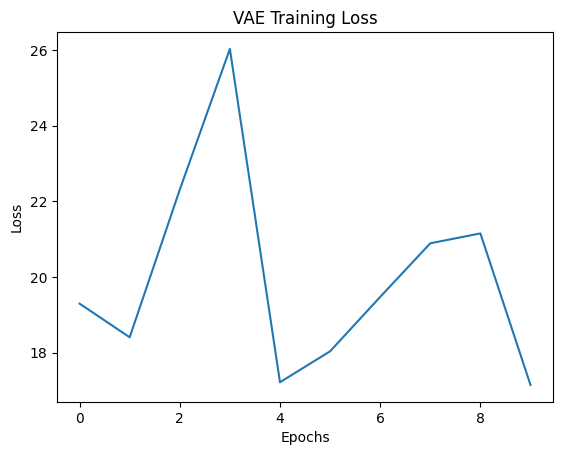

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
import os
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import glob

# Define the encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu4 = nn.ReLU()

        # Flatten the output of the convolutional layers
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 7, 128)
        self.relu5 = nn.ReLU()
        self.fc_mu = nn.Linear(128, 2)
        self.fc_logvar = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu5(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(2, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 256 * 7 * 7)
        self.relu2 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        # Convolutional transpose layers
        self.convt1 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.convt2 = nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1)
        self.relu4 = nn.ReLU()
        self.convt3 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1)
        self.relu5 = nn.ReLU()
        self.convt4 = nn.ConvTranspose2d(16, 3, 3, padding=1)

    def forward(self, z):
        z = self.fc1(z)
        z = self.relu1(z)
        z = self.fc2(z)
        z = self.relu2(z)
        z = z.view(-1, 256, 7, 7)
        z = self.convt1(z)
        z = self.relu3(z)
        z = self.convt2(z)
        z = self.relu4(z)
        z = self.convt3(z)
        z = self.relu5(z)
        z = self.convt4(z)
        z = self.sigmoid(z)
        return z

# Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

        print(self.encoder)
        print(self.decoder)

    def reparametrize(self, mu, sigma):
        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, sigma = self.encoder(x)[0], self.encoder(x)[1]
        z = self.reparametrize(mu, sigma)
        x_hat = self.decoder(z)
        return x_hat, mu, sigma

# Load the dataset
def load_dataset(folder_path):
    transform = transforms.Compose([
        transforms.Resize((25, 25)),
        transforms.ToTensor(),
    ])

    dataset = datasets.ImageFolder(root=folder_path, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
    return dataloader

def vae_loss(recon_x, x, mu, logvar):
    batch_size = x.size(0)
    # Compute MSE loss
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum') / batch_size

    # KL Divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size

    return MSE + KLD

# Training function
def train_vae(model, dataloader, optimizer, num_epochs=1000, save_interval=50):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            optimizer.zero_grad()
            inputs, _ = data
            inputs = inputs.to(device)

            recon_data, mu, logvar = model(inputs)
            loss = vae_loss(recon_data, inputs, mu, logvar)
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Save model every save_interval epochs
        if (epoch + 1) % save_interval == 0:
            torch.save(model.state_dict(), f"model_folder/vae_model_epoch_{epoch+1}.pth")

    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('VAE Training Loss')
    plt.show()


ngpu = 1

# Set device
device = torch.device("cuda:2" if (torch.cuda.is_available() and ngpu > 1) else "cpu")

# Initialize the VAE model and optimizer
vae_model = VAE().to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

# Load the training dataset
train_dataloader = load_dataset('data/training/Center/')

# Train the VAE
train_vae(vae_model, train_dataloader, optimizer, num_epochs=10, save_interval=50)

def generate_images(model_path, output_folder, num_images=100):
    print(f"Generating images from model: {model_path}")
    
    # Instantiate the VAE model and move it to the device
    vae = VAE().to(device)
    
    # Load the trained state dict onto the model
    vae.load_state_dict(torch.load(model_path))
    vae.eval()

    # Create the decoder
    decoder = vae.decoder
    # Create a folder for each model
    model_name = os.path.splitext(os.path.basename(model_path))[0]
    model_output_folder = os.path.join(output_folder, model_name)
    os.makedirs(model_output_folder, exist_ok=True)

    with torch.no_grad():
        for _ in range(num_images):
            # Generate random noise
            z = torch.randn(1, vae.encoder.fc_mu.out_features).to(device)

            # Generate new samples using the decoder
            sample = decoder(z).cpu()

            # Save the generated images
            image = transforms.ToPILImage()(sample.squeeze())
            image = image.resize((64, 64))
            image.save(os.path.join(model_output_folder, f'generated_image_{_ + 1}.png'))

# Output folder for generated images
output_folder = 'generated_samples'
models_folder = 'model_folder'

# Generate images for each saved VAE model
for model_file in sorted(glob.glob(os.path.join(models_folder, 'vae_model_epoch_*.pth'))):
    generate_images(model_file, output_folder, num_images=100)

In [14]:
pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import argparse
import os
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision.models import inception_v3
from glob import glob
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance
from skimage.metrics import peak_signal_noise_ratio

### Frechet Inception Distance (FID), Kernel Inception Distance (KID) & Peak Signal-to-Noise Ratio (PSNR) ###

#Initialize the Frechet Inception Distance 
fid = FrechetInceptionDistance(feature=64)

psnr_values = []

# Initialize the Kernel Inception Distance metric
kid = KernelInceptionDistance(subset_size=50)
# Function to load an image using PIL
def load_image_function(image_path):
    try:
        # Open the image using PIL (assuming the image format is compatible with PIL)
        image = Image.open(image_path)
        # Convert the image to RGB (in case of grayscale images)
        image = image.convert('RGB')
        return image
    except Exception as e:
        print(f"Error loading image at {image_path}: {e}")
        return None


# Define the transformation to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image data
])

# Path to the directory containing the generated folders
generated_images_path =  'edgering-vae/generated_samples'

# Path to the directory containing the testing images
testing_images_path = 'data/testing/None/none-class'


# Iterate through each generated folder
for generated_folder_name in os.listdir(generated_images_path):
    generated_folder_path = os.path.join(generated_images_path, generated_folder_name)
    
    # Lists to accumulate preprocessed images for the current folder
    generated_images_stack = []
    testing_images_stack = []
    
    # Preprocess generated images for the current folder
    for generated_image_name in os.listdir(generated_folder_path):
        generated_image_path = os.path.join(generated_folder_path, generated_image_name)
        generated_image = load_image_function(generated_image_path)
        if generated_image:
            preprocessed_generated_image = transform(generated_image)
            preprocessed_generated_image = (preprocessed_generated_image * 255).to(torch.uint8)
            generated_images_stack.append(preprocessed_generated_image)
    
    # Preprocess testing images (assuming it's the same set for all generated folders)
    for testing_image_name in os.listdir(testing_images_path):
        testing_image_path = os.path.join(testing_images_path, testing_image_name)
        
        # Check if the item in the directory is a file and not a directory
        if os.path.isfile(testing_image_path):
            testing_image = load_image_function(testing_image_path)
            if testing_image:
                preprocessed_testing_image = transform(testing_image)
                preprocessed_testing_image = (preprocessed_testing_image * 255).to(torch.uint8)
                testing_images_stack.append(preprocessed_testing_image)
    
    # Check if testing_images_stack is not empty before stacking
    if testing_images_stack and generated_images_stack:

        generated_images_stack = torch.stack(generated_images_stack)
        testing_images_stack = torch.stack(testing_images_stack)
    
        psnr_folder_values = []
        
        for i in range(len(testing_images_stack)):
            psnr_value = peak_signal_noise_ratio(
                testing_images_stack[i].cpu().numpy().transpose(1, 2, 0),
                generated_images_stack[i].cpu().numpy().transpose(1, 2, 0),
                data_range=255
            )
            psnr_folder_values.append(psnr_value)

        # Accumulate PSNR values for the current folder
        psnr_values.extend(psnr_folder_values)

        # Compute mean and std dev of PSNR for the current folder
        psnr_mean = np.mean(psnr_folder_values)
        psnr_std = np.std(psnr_folder_values)
                          
        # Convert accumulated image stacks to tensors
        # Update the FID metric with the generated and testing image stacks for the current folder
        fid.update(generated_images_stack, real=True)
        fid.update(testing_images_stack, real=False)
        kid.update(generated_images_stack, real=True)
        kid.update(testing_images_stack, real=False)
    
        # Compute FID score for the current folder
        fid_score = fid.compute()
        kid_mean, kid_std = kid.compute()

        # Print PSNR mean and std dev for the current folder
        with open('none_psnr_results.txt', 'w') as psnr_file:
            output = f"{generated_folder_name}: PSNR Mean: {psnr_mean}\n"
            output += f"PSNR Standard Deviation: {psnr_std}\n"
            psnr_file.write(output)
            
        print(f"{generated_folder_name}: PSNR Mean: {psnr_mean}")
        print(f"PSNR Standard Deviation: {psnr_std}\n")
        
        # Print FID and KID scores for the current folder
        with open('none_fid_results.txt', 'w') as fid_file:
            output = f"{generated_folder_name}: FID Score: {fid_score.item()}\n"
            fid_file.write(output)
            
        print(f"{generated_folder_name}: FID Score: {fid_score.item()}")
        
        with open('none_kid_results.txt', 'w') as kid_file:
            output = f"KID Mean Score: {kid_mean.item()}\n"
            output += f"KID Standard Deviation: {kid_std.item()}\n"
            kid_file.write(output)
            
        print(f"Folder: {generated_folder_name}, KID Mean Score: {kid_mean.item()}")
        print(f"KID Standard Deviation: {kid_std.item()}\n")
        
        # Reset the FID and KID metrics for the next folder
        fid.reset()
        kid.reset()
    else:
        print(f"No valid testing images found in {testing_images_path}")

#Inception Score 

# Initialize the Inception Score metric
inception = InceptionScore()

# Iterate through each folder in the specified directory
for folder_name in os.listdir(generated_images_path):
    folder_path = os.path.join(generated_images_path, folder_name)
    
    # Check if the item in the directory is a folder
    if os.path.isdir(folder_path):
        folder_images = []
        
        # Iterate through each image in the folder
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            # Load the image (assuming PIL Image format)
            # Replace 'load_image_function' with the appropriate function to load your images
            image = load_image_function(image_path)
            # Apply transformations
            preprocessed_image = transform(image)
            folder_images.append(preprocessed_image)
        
        if folder_images:
            # Stack preprocessed images into a tensor
            folder_images = torch.stack(folder_images)
        
            # Update the Inception Score metric with the preprocessed images for the folder
            inception.update((folder_images * 255).to(torch.uint8))
        
            # Compute Inception Score for the folder
            folder_score_mean, folder_score_std = inception.compute()
        
            # Print mean and standard deviation of Inception Scores for the current folder
            with open('none_inception_score_results.txt', 'a') as file:
                output = f"Folder: {folder_name}\nMean Inception Score: {folder_score_mean.item()}\nStandard Deviation of Inception Scores:{folder_score_std.item()}\n"
                file.write(output)
            print(f"Folder: {folder_name}")
            print(f"Mean Inception Score: {folder_score_mean.item()}")
            print(f"Standard Deviation of Inception Scores: {folder_score_std.item()}")
        
            # Reset the Inception Score metric for the next folder
            inception.reset()
        else:
            print(f"No valid images found in {folder_path}")

vae_model_epoch_500: PSNR Mean: 8.642550354198148
PSNR Standard Deviation: 1.4140970074700707

vae_model_epoch_500: FID Score: 7.006209850311279
Folder: vae_model_epoch_500, KID Mean Score: 0.6699358224868774
KID Standard Deviation: 0.010821297764778137

vae_model_epoch_750: PSNR Mean: 8.649208827275505
PSNR Standard Deviation: 1.3672570572623877

vae_model_epoch_750: FID Score: 7.189376354217529
Folder: vae_model_epoch_750, KID Mean Score: 0.7203975915908813
KID Standard Deviation: 0.010084999725222588

vae_model_epoch_800: PSNR Mean: 8.592485151158913
PSNR Standard Deviation: 1.4573418894744272

vae_model_epoch_800: FID Score: 7.243336200714111
Folder: vae_model_epoch_800, KID Mean Score: 0.7374926209449768
KID Standard Deviation: 0.011169071309268475

vae_model_epoch_850: PSNR Mean: 8.39638659958905
PSNR Standard Deviation: 1.493114097947135

vae_model_epoch_850: FID Score: 7.771925449371338
Folder: vae_model_epoch_850, KID Mean Score: 0.6218482851982117
KID Standard Deviation: 0.00

NotADirectoryError: [Errno 20] Not a directory: 'None-vae/generated_samples/.DS_Store'